Assignment: ML Training and Validation on Cybersecurity Logs - CYFORTE TEAM 

Imports and environment setup:

In [153]:
import pandas as pd 
import numpy as np

In [154]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [155]:
from sklearn.ensemble import RandomForestClassifier

In [156]:
import json
import re
from pathlib import Path

Our datasets consists of raw EDR logs where each line is an entry containing a JSON payload.
To transform complex, raw log data from various systems into a readable format, we perform Log Parsing :

In [157]:

def parse_logs(file_path, label):
    records = []
    with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            if not line.strip():
                continue
            parts = line.split("|", 1)
            if len(parts) < 2:
                continue
            json_part = parts[1].strip()
            try:
                payload = json.loads(json_part)
                payload["label"] = label
                records.append(payload)
            except json.JSONDecodeError:
                continue
            except Exception:
                continue
    return records
true_p = parse_logs("edr_tp.log", label=1)
false_p = parse_logs("edr_fp.log", label=0)

all_records = true_p + false_p
output_file = "structured_edr_logs.json"
with open(output_file, "w") as f:
    json.dump(all_records, f, indent=2)
print(f"Total records stored: {len(all_records)}")
print(f"True Positives (label=1): {len(true_p)}")
print(f"False Positives (label=0): {len(false_p)}")
print(json.dumps(all_records[0], indent=2))


Total records stored: 134
True Positives (label=1): 103
False Positives (label=0): 31
{
  "severity": 3,
  "session": "00000000000000000000000000000000",
  "attributes": {
    "site.id": 2355472410673209708,
    "finding_info.uid_alt": "2377526249015893777",
    "finding_info.created_time": 1766651980812,
    "metadata.logged_time": 1766652015032,
    "s1_detection_metadata.scope_id": 2355472410706764141,
    "device.os.name": "Windows 10 Home",
    "status_id": 1,
    "activity_id": 1,
    "finding_info.analytic.type_id": 99,
    "confidence_id": 3,
    "metadata.profiles": "[agent,osint]",
    "s1_detection_metadata.account_id": 763444780293711812,
    "device.owner.name": "vboxuser",
    "metadata.correlation_uid": "",
    "verdict_id": 0,
    "finding_info.related_analytics": "[]",
    "finding_info.first_seen_time": 1766651980812,
    "finding_info.last_seen_time": 1766652015029,
    "device.type_id": 99,
    "metadata.extensions": "[{\"uid\":\"996\",\"name\":\"s1\",\"version\":\"

This function will read raw EDR log lines, extract and parse the JSON payload from each entry, assign a TP/FP label and discard malformed entries.
To confirm that the raw EDR logs have been converted into a structured JSON format, the generated JSON file is reloaded and a sample record is displayed.

In [158]:
len(true_p) , len(false_p)

(103, 31)

We observe that there is a clear class imbalance : 103 TP vs 31 FP. 


In [159]:

tp_count = len(true_p)
fp_count = len(false_p)
total = tp_count + fp_count
print("Dataset Statistics:")
print("-" * 40)
print(f"True Positives (TP):  {tp_count:3d} ({tp_count/total*100:.1f}%)")
print(f"False Positives (FP): {fp_count:3d} ({fp_count/total*100:.1f}%)")
print(f"Total Samples:        {total:3d}")
print("-" * 40)
print(f"Imbalance Ratio:     {tp_count/fp_count:.2f}:1")



Dataset Statistics:
----------------------------------------
True Positives (TP):  103 (76.9%)
False Positives (FP):  31 (23.1%)
Total Samples:        134
----------------------------------------
Imbalance Ratio:     3.32:1


Feature Extraction : Raw EDR logs are not directly usable for machine learning. We will extract some of meaningful
features from the logs. 

In [160]:
def feature_extraction(record):
    atrb = record.get("attributes", {})

    features = {
        "severity": record.get("severity"),
        "confidence_id": atrb.get("confidence_id"),
        "activity_id": atrb.get("activity_id"),
        "analytic_type": atrb.get("finding_info.analytic.type"),
        "analytic_category": atrb.get("finding_info.analytic.category"),
        "os_name": atrb.get("device.os.name"),
        "classification_id": atrb.get("s1_classification_id"),
        "has_mitre_attack": int(
            bool(atrb.get("finding_info.related_events")) and
            len(str(atrb.get("finding_info.related_events"))) > 2
        ),
        "label": record.get("label")
    }

    return features

    

The extracted features are converted into a pandas DataFrame. Each row corresponds to one alert and each column represents a feature or label

In [161]:
all_records = true_p + false_p
feature_rows = [feature_extraction(r) for r in all_records]
df = pd.DataFrame(feature_rows)
df.head()


,severity,confidence_id,activity_id,analytic_type,analytic_category,os_name,classification_id,has_mitre_attack,label
0,3,3.0,1,Static,Reputation,Windows 10 Home,37,0,1
1,3,3.0,2,Static,Reputation,Windows 10 Home,37,0,1
2,3,3.0,1,Static,Reputation,Windows 10 Home,37,0,1
3,3,3.0,2,Static,Reputation,Windows 10 Home,37,0,1
4,3,3.0,1,Static,Reputation,Windows 10 Home,37,0,1


Before training the model, we will assess data quality. We will compute the the proportion of missing values per feature.

In [162]:
df.isnull().mean()

severity             0.000000
confidence_id        0.052239
activity_id          0.000000
analytic_type        0.000000
analytic_category    0.000000
os_name              0.052239
classification_id    0.000000
has_mitre_attack     0.000000
label                0.000000
dtype: float64

To understand the distribution of True Positives and False Positives in the dataset, we will plot a graph and understand visually.

<Axes: title={'center': 'TP vs FP Distribution'}, xlabel='label'>

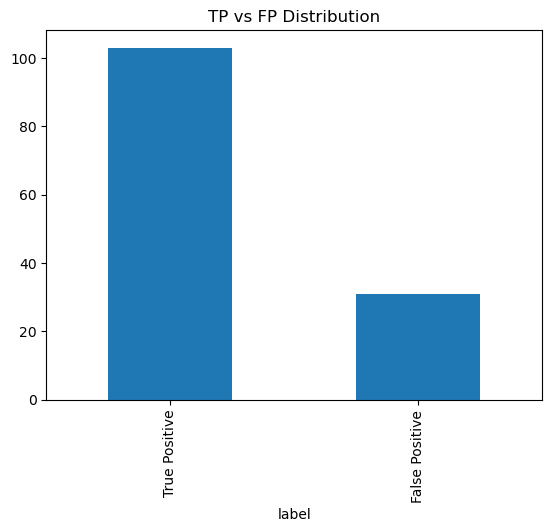

In [163]:
df["label"].value_counts().rename({0: "False Positive", 1: "True Positive"}).plot(
    kind="bar",
    title="TP vs FP Distribution"
)


Pre processing pipeline design : 
The constructed preprocessing pipeline will pass numerical features unchanged and One-Hot encode categorical features.
Numerical features such as severity, IDs etc are passed through without modification, as tree based models like Random Forest do not require feature scaling. Categorical features are converted into numerical representations using One-Hot Encoding. ColumnTransformer ensures consistency between test and training data and prevent data leakage

In [164]:
X = df.drop(columns=["label"])
y = df["label"]

categorical_features = ["analytic_category", "os_name"]

numerical_features = [
    "severity",
    "confidence_id",
    "activity_id",
    "classification_id",
    "has_mitre_attack"
]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

Our problem is not a normal classification problem. We have raw logs, same severity alerts can be both true positive or false positive,
decisions are not linear, hence we will use a non linear model. Random Forest model will be used due to non linear interaction of features


In [131]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)


After defining the machine learning pipeline we will perform cross-validation to check how stable and reliable the model is.
The training data is split into multiple folds using Stratified K-Fold
cross-validation and for each fold the model is trained on part of the data, tested on unseen data and F1-score is recorded

In [132]:
from sklearn.model_selection import cross_val_score, StratifiedKFold


In [133]:
rf_pipeline_cv = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200, 
        max_depth=10, 
        class_weight="balanced", 
        random_state=42
    ))
])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    rf_pipeline_cv, 
    X_train, 
    y_train, 
    cv=cv, 
    scoring='f1'
)

print("Cross-Validation Results:")
print(f"F1 Scores per fold: {cv_scores}")
print(f"Mean F1 Score: {cv_scores.mean():.3f}")
print(f"Standard Deviation: {cv_scores.std():.3f}")
print(f"95% Confidence Interval: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

Cross-Validation Results:
F1 Scores per fold: [0.9375     0.9375     0.90322581 0.89655172 0.93333333]
Mean F1 Score: 0.922
Standard Deviation: 0.018
95% Confidence Interval: 0.922 (+/- 0.036)


Hyperparameter tuning using GridSearchCV:
We will use GridSearchCV to automatically find the best model settings by trying different combinations and selecting the one that performs best on validation data.

In [134]:
from sklearn.model_selection import GridSearchCV

In [135]:
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [5, 10, 15, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}
rf_pipeline_grid = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        class_weight="balanced", 
        random_state=42
    ))
])
grid_search = GridSearchCV(
    rf_pipeline_grid,
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
print("Performing Grid Search...")
grid_search.fit(X_train, y_train)
print("\nBest Hyperparameters:")
print(grid_search.best_params_)
print(f"\nBest Cross-Validation F1 Score: {grid_search.best_score_:.3f}")
rf_pipeline = grid_search.best_estimator_

Performing Grid Search...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best Hyperparameters:
{'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}

Best Cross-Validation F1 Score: 0.922


We will train the model using a Random Forest classifier, which will combine multiple decision trees to distinguish between TruePositive and False Positive alerts.


In [136]:
rf_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(n_estimators=200, max_depth=10, 
                                     class_weight="balanced", random_state=42))
])
rf_pipeline.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


THIS LINE trains the model:
rf_pipeline.fit(X_train, y_train)

Classification Report:

In [137]:
rf_preds = rf_pipeline.predict(X_test)
print(classification_report(y_test,rf_preds))


              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.95      0.98        21

    accuracy                           0.96        27
   macro avg       0.93      0.98      0.95        27
weighted avg       0.97      0.96      0.96        27



The classification report summarizes: Precision , Recall and F1-score



Random Forest classifier provides a feature importance score foreach input feature, indicating how frequently and effectively that feature was used to split data across decision trees. A graph for feature importances is hence plotted as follows:


<Axes: title={'center': 'Top Feature Importances'}>

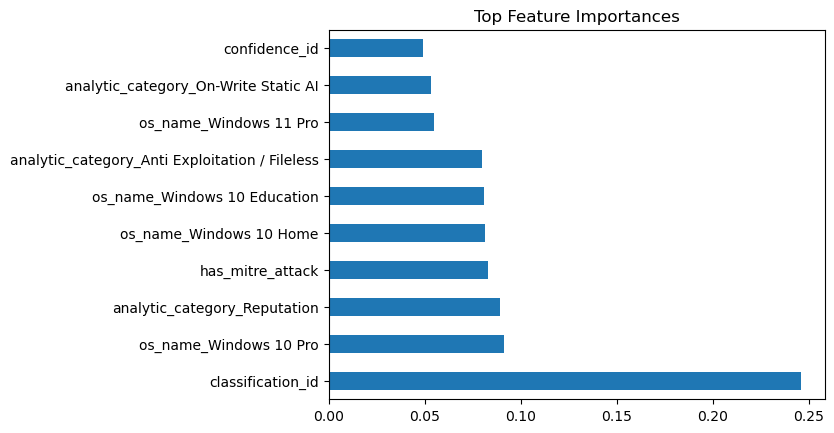

In [138]:
importances = rf_pipeline.named_steps["model"].feature_importances_

cat_cols = rf_pipeline.named_steps["preprocess"].named_transformers_["cat"].get_feature_names_out(categorical_features)
cols = numerical_features + list(cat_cols)

pd.Series(importances, index=cols).sort_values(ascending=False).head(10).plot(kind="barh", title="Top Feature Importances")

The analysis reveals that classification_id is the strongest predictor in distinguishing true positive alerts from false positives.

Confusion Matrix: The effectiveness of alert suppression and threat retention will be shown in the confusion matrix

In [139]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

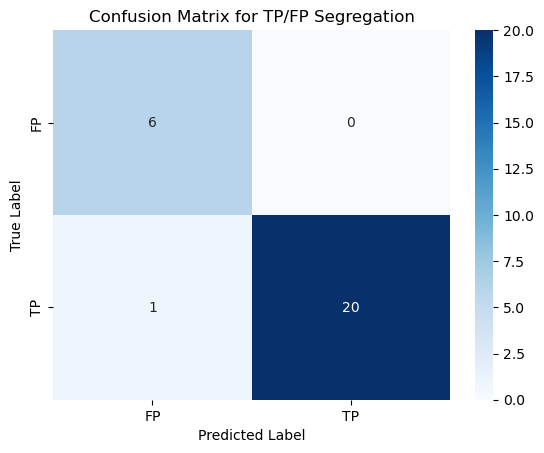

In [140]:
cm = confusion_matrix(y_test, rf_preds)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["FP", "TP"],
    yticklabels=["FP", "TP"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for TP/FP Segregation")
plt.show()

The matrix shows that:
6 False Positives correctly identified as FP 
0 False Positives misclassified as TP 
1 True Positive misclassified as FP (minor error)
20 True Positives correctly identified as TP 
Hence, Overall: 26/27 correct = 96.3% accuracy 


Now, we plot a precision recall curve , particularly important for security datasets that are unbalanced.
It depicts the change in precision and recall values or the trade-off between detecting true threats and minimizing false positives
across different decision thresholds. 

In [141]:
from sklearn.metrics import precision_recall_curve

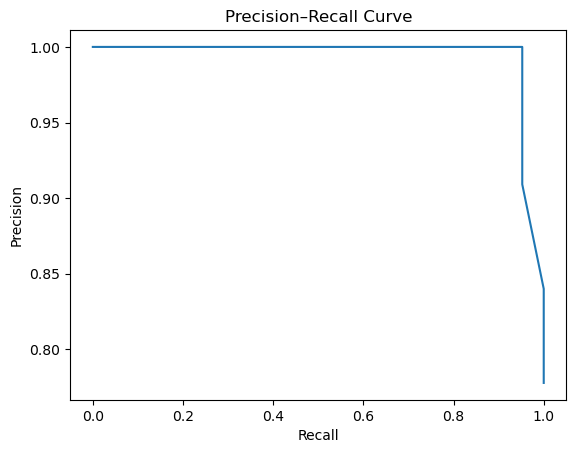

In [142]:
y_probs = rf_pipeline.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_probs)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()

We observe that the model maintains high precision across most recall values

Threshold Sensitivity Analysis: This plot will show  how adjusting the classification threshold will impact precision and recall.

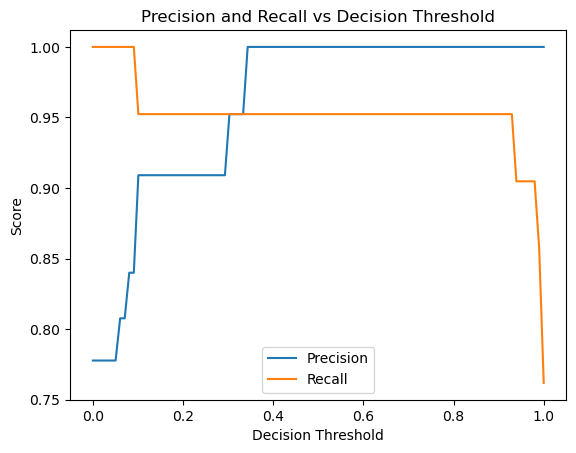

In [143]:
thresholds = np.linspace(0, 1, 100)
precisions = []
recalls = []
for thresh in thresholds:
    preds = (y_probs >= thresh).astype(int)
    tp = ((preds == 1) & (y_test == 1)).sum()
    fp = ((preds == 1) & (y_test == 0)).sum()
    fn = ((preds == 0) & (y_test == 1)).sum()
    prec = tp / (tp + fp) if (tp + fp) > 0 else 1.0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    
    precisions.append(prec)
    recalls.append(rec)

plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Decision Threshold")
plt.legend()
plt.show()

The graph shows that at lower thresholds, recall is higher but precision is lower, meaning more alerts are flagged as threats. As the threshold increases, precision improves while recall decreases.

To conclude,
this notebook is a complete machine learning pipeline trained  to classify EDR alerts into True Positives and False Positives using raw
security logs as input. 
First, unstructured
log data was converted into a structured format,to confirm a sample was printed followed by meaningful feature
extraction.

A Random Forest classifier was used due to its ability to handle
non-linear relationships and mixed data types. Model
performance was evaluated using metrics such as F1-score,
precision, and recall.

Cross-validation and hyperparameter tuning were applied to ensure model
stability and prevent overfitting. Visual analysis using confusion
matrices, precision–recall curves and threshold sensitivity plots helped validate both model performance.

Overall, the results demonstrate that our model can effectively
reduce false positives while retaining true security alerts.

Submitted by: Aditi Sikarwar 
( aditi.sikarwar25@gmail.com , 6280335859 )